In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# torch.cuda.is_available()
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load results

In [2]:
true_counts = torch.load("results/true_counts.pt")
true_fluxes = torch.load("results/true_fluxes.pt")
true_locs = torch.load("results/true_locs.pt")
true_total_intensities = torch.load("results/true_total_intensities.pt")
images = torch.load("results/images.pt")
num_images = images.shape[0]
max_objects = true_fluxes.shape[1]

sep_estimated_count = torch.load("results/sep_estimated_count.pt")
sep_estimated_total_flux = torch.load("results/sep_estimated_total_flux")
sep_reconstruction = torch.load("results/sep_reconstruction.pt")

smc_posterior_mean_count = torch.load("results/smc_posterior_mean_count.pt")
smc_posterior_mean_total_flux = torch.load("results/smc_posterior_mean_total_flux.pt")
smc_reconstruction = torch.load("results/smc_reconstruction.pt")
smc_runtime = torch.load("results/smc_runtime.pt")
smc_num_iters = torch.load("results/smc_num_iters.pt")

### SEP results

In [3]:
sep_prop_correct = ((sep_estimated_count == true_counts).sum()/num_images)
sep_rmse = ((sep_estimated_count - true_counts)**2).mean().sqrt()
sep_mae = (sep_estimated_count - true_counts).abs().mean()
sep_rmse_total_flux = ((sep_estimated_total_flux - true_fluxes.sum(1))**2).mean().sqrt()
sep_mae_total_flux = (sep_estimated_total_flux - true_fluxes.sum(1)).abs().mean()

print(f"proportion correct = {sep_prop_correct}")
print(f"RMSE (source count) = {sep_rmse}")
print(f"MAE (source count) = {sep_mae}")
print(f"RMSE (total flux) = {sep_rmse_total_flux}")
print(f"MAE (total flux) = {sep_mae_total_flux}")

proportion correct = 0.21000000834465027
RMSE (source count) = 4.57340145111084
MAE (source count) = 3.576000213623047
RMSE (total flux) = 40954.375
MAE (total flux) = 34967.8203125


In [4]:
sep_mean_estimated_count_by_count = torch.zeros(max_objects)
sep_bounds_estimated_count_by_count = torch.zeros(max_objects, 2)
sep_num_correct_by_count = torch.zeros(max_objects)
sep_prop_correct_by_count = torch.zeros(max_objects)
sep_rmse_by_count = torch.zeros(max_objects)
sep_mae_by_count = torch.zeros(max_objects)
sep_bounds_mae_by_count = torch.zeros(max_objects, 2)
sep_rmse_total_flux_by_count = torch.zeros(max_objects)
sep_mae_total_flux_by_count = torch.zeros(max_objects)

for num in range(max_objects):
    print(f"true number of sources = {num}")
    sep_mean_estimated_count_by_count[num] = sep_estimated_count[true_counts==num].mean()
    print(f"mean estimated number of sources = {sep_mean_estimated_count_by_count[num].item()}")
    sep_bounds_estimated_count_by_count[num] = sep_estimated_count[true_counts==num].quantile(torch.tensor((0.05, 0.95)))
    
    sep_rmse_by_count[num] = ((sep_estimated_count[true_counts==num] - true_counts[true_counts==num])**2).mean().sqrt()
    print(f"RMSE (source count) across {num_images} images = ", sep_rmse_by_count[num].item())
    
    sep_mae_by_count[num] = ((sep_estimated_count[true_counts==num] - true_counts[true_counts==num]).abs()).mean()
    print(f"MAE (source count) across {num_images} images = ", sep_mae_by_count[num].item())
    sep_bounds_mae_by_count[num] = ((sep_estimated_count[true_counts==num] - true_counts[true_counts==num]).abs()).quantile(torch.tensor((0.05, 0.95)))
    
    sep_rmse_total_flux_by_count[num] = ((sep_estimated_total_flux[true_counts==num] - true_fluxes[true_counts==num].sum(1))**2).mean().sqrt()
    print(f"RMSE (total flux) across {num_images} images = ", sep_rmse_total_flux_by_count[num].item())
    
    sep_mae_total_flux_by_count[num] = ((sep_estimated_total_flux[true_counts==num] - true_fluxes[true_counts==num].sum(1)).abs()).mean()
    print(f"MAE (total flux) across {num_images} images = ", sep_mae_total_flux_by_count[num].item())
    
    sep_num_correct_by_count[num] = (sep_estimated_count[true_counts==num].round() == true_counts[true_counts==num]).sum()
    sep_prop_correct_by_count[num] = sep_num_correct_by_count[num]/(true_counts==num).sum()
    print(f"correct number of sources detected in {sep_num_correct_by_count[num]} of the {(true_counts==num).sum()} images (accuracy = {sep_prop_correct_by_count[num]})\n\n\n")

true number of sources = 0
mean estimated number of sources = 0.0
RMSE (source count) across 1000 images =  0.0
MAE (source count) across 1000 images =  0.0
RMSE (total flux) across 1000 images =  0.0
MAE (total flux) across 1000 images =  0.0
correct number of sources detected in 96.0 of the 96 images (accuracy = 1.0)



true number of sources = 1
mean estimated number of sources = 0.8292682766914368
RMSE (source count) across 1000 images =  0.4131969213485718
MAE (source count) across 1000 images =  0.17073169350624084
RMSE (total flux) across 1000 images =  42769.9921875
MAE (total flux) across 1000 images =  41202.3671875
correct number of sources detected in 68.0 of the 82 images (accuracy = 0.8292682766914368)



true number of sources = 2
mean estimated number of sources = 1.3863636255264282
RMSE (source count) across 1000 images =  0.7833494544029236
MAE (source count) across 1000 images =  0.6136363744735718
RMSE (total flux) across 1000 images =  61507.62890625
MAE (total flu

### SMC results

In [5]:
print(f"RMSE (source count) across {num_images} images:", ((smc_posterior_mean_count - true_counts)**2).mean().sqrt().item())
print(f"MAE (source count) across {num_images} images:", ((smc_posterior_mean_count - true_counts).abs()).mean().item())
print(f"RMSE (total flux) across {num_images} images:", ((smc_posterior_mean_total_flux - true_fluxes.sum(1))**2).mean().sqrt().item())
print(f"MAE (total flux) across {num_images} images:", ((smc_posterior_mean_total_flux - true_fluxes.sum(1)).abs()).mean().item())
print(f"correct number of sources detected in {(smc_posterior_mean_count.round() == true_counts).sum()} of the {num_images} images (accuracy = {(smc_posterior_mean_count.round() == true_counts).sum()/num_images})")
print(f"number of iterations: mean = {smc_num_iters.mean().int()}, minimum = {smc_num_iters.min().int()}, median = {smc_num_iters.median().int()}, maximum = {smc_num_iters.max().int()}")
print(f"runtime: mean = {smc_runtime.mean().int()}, minimum = {smc_runtime.min().int()}, median = {smc_runtime.median().int()}, maximum = {smc_runtime.max().int()}\n\n\n")

for i in range(num_images):
    print(f"image {i+1} of {num_images} took {smc_num_iters[i].int()} iterations:   ",
        "true s:", true_counts[i].int().item(),
        "   estimated s:", "{:.3f}".format(smc_posterior_mean_count[i].round(decimals = 4).item()),
        "   true total flux:", true_fluxes[i].sum().round().int().item(),
        "   estimated total flux:", smc_posterior_mean_total_flux[i].round(decimals = 4).item())

RMSE (source count) across 1000 images: 0.4004518389701843
MAE (source count) across 1000 images: 0.22922490537166595
RMSE (total flux) across 1000 images: 1900.47998046875
MAE (total flux) across 1000 images: 1427.4366455078125
correct number of sources detected in 798 of the 1000 images (accuracy = 0.7980000376701355)
number of iterations: mean = 82, minimum = 48, median = 66, maximum = 501
runtime: mean = 58, minimum = 32, median = 46, maximum = 418



image 1 of 1000 took 52 iterations:    true s: 4    estimated s: 4.064    true total flux: 269012    estimated total flux: 270889.3125
image 2 of 1000 took 61 iterations:    true s: 5    estimated s: 5.011    true total flux: 317353    estimated total flux: 316240.59375
image 3 of 1000 took 69 iterations:    true s: 0    estimated s: 0.000    true total flux: 0    estimated total flux: 9.999999747378752e-05
image 4 of 1000 took 149 iterations:    true s: 10    estimated s: 11.001    true total flux: 708908    estimated total flux: 708

In [6]:
smc_mean_posterior_mean_count_by_count = torch.zeros(max_objects)
smc_bounds_posterior_mean_count_by_count = torch.zeros(max_objects, 2)
smc_num_correct_by_count = torch.zeros(max_objects)
smc_prop_correct_by_count = torch.zeros(max_objects)
smc_rmse_by_count = torch.zeros(max_objects)
smc_mae_by_count = torch.zeros(max_objects)
smc_bounds_mae_by_count = torch.zeros(max_objects, 2)
smc_rmse_total_flux_by_count = torch.zeros(max_objects)
smc_mae_total_flux_by_count = torch.zeros(max_objects)

for num in range(max_objects):
    print(f"true number of sources = {num}")
    
    smc_mean_posterior_mean_count_by_count[num] = smc_posterior_mean_count[true_counts==num].mean()
    print(f"estimated number of sources for images where s = {num}:", smc_mean_posterior_mean_count_by_count[num].item())
    smc_bounds_posterior_mean_count_by_count[num] = smc_posterior_mean_count[true_counts==num].quantile(torch.tensor((0.05, 0.95),device=device))
    
    smc_rmse_by_count[num] = ((smc_posterior_mean_count[true_counts==num] - true_counts[true_counts==num])**2).mean().sqrt()
    print(f"RMSE (source count) across {(true_counts==num).sum()} images:", (smc_rmse_by_count[num].item()))
    
    smc_mae_by_count[num] = ((smc_posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).mean()
    print(f"MAE (source count) across {(true_counts==num).sum()} images:", (smc_mae_by_count[num].item()))
    smc_bounds_mae_by_count[num] = ((smc_posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).quantile(torch.tensor((0.05, 0.95),device=device))
    
    smc_rmse_total_flux_by_count[num] = ((smc_posterior_mean_total_flux[true_counts==num] - true_fluxes[true_counts==num].sum(1))**2).mean().sqrt()
    print(f"RMSE (total flux) across {(true_counts==num).sum()} images:", (smc_rmse_total_flux_by_count[num].item()))
    
    smc_mae_total_flux_by_count[num] = ((smc_posterior_mean_total_flux[true_counts==num] - true_fluxes[true_counts==num].sum(1)).abs()).mean()
    print(f"MAE (total flux) across {(true_counts==num).sum()} images:", (smc_mae_total_flux_by_count[num].item()))
    
    smc_num_correct_by_count[num] = (smc_posterior_mean_count[true_counts==num].round() == true_counts[true_counts==num]).sum()
    smc_prop_correct_by_count[num] = smc_num_correct_by_count[num]/(true_counts==num).sum()
    print(f"correct number of sources detected in {smc_num_correct_by_count[num].int()} of the {(true_counts==num).sum()} images (accuracy = {smc_prop_correct_by_count[num]})")
    
    print(f"number of iterations: minimum = {smc_num_iters[true_counts==num].min().int()}, median = {smc_num_iters[true_counts==num].median().int()}, maximum = {smc_num_iters[true_counts==num].max().int()}\n")

true number of sources = 0
estimated number of sources for images where s = 0: 1.3139540442352882e-06
RMSE (source count) across 96 images: 2.1682417354895733e-06
MAE (source count) across 96 images: 1.3139540442352882e-06
RMSE (total flux) across 96 images: 0.006898443214595318
MAE (total flux) across 96 images: 0.0028557064943015575
correct number of sources detected in 96 of the 96 images (accuracy = 1.0)
number of iterations: minimum = 67, median = 69, maximum = 72

true number of sources = 1
estimated number of sources for images where s = 1: 1.0034077167510986
RMSE (source count) across 82 images: 0.014625458978116512
MAE (source count) across 82 images: 0.003407779149711132
RMSE (total flux) across 82 images: 1200.357177734375
MAE (total flux) across 82 images: 979.1539306640625
correct number of sources detected in 82 of the 82 images (accuracy = 1.0)
number of iterations: minimum = 63, median = 66, maximum = 69

true number of sources = 2
estimated number of sources for images

### Bootstrap CIs

In [7]:
torch.manual_seed(0)

### SMC
num_boot_samples = 10000
smc_bounds_prop_correct_by_count = torch.zeros(max_objects, 2)

for num in range(max_objects):
    boot_orig = torch.stack((smc_posterior_mean_count[true_counts==num].round(), true_counts[true_counts==num]), dim = 1)
    boot_prop_correct = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = boot_orig[(torch.multinomial(torch.arange(boot_orig.size(0)).double(), num_samples = boot_orig.size(0), replacement = True))]
        boot_prop_correct[j] = (boot_sample[:,0] == boot_sample[:,1]).sum()/boot_orig.size(0)
    
    smc_bounds_prop_correct_by_count[num] = boot_prop_correct.quantile(torch.tensor((0.05, 0.95),device=device))

### SEP
sep_bounds_prop_correct_by_count = torch.zeros(max_objects, 2)

for num in range(max_objects):
    boot_orig = torch.stack((sep_estimated_count[true_counts==num].round(), true_counts[true_counts==num]), dim = 1)
    boot_prop_correct = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = boot_orig[(torch.multinomial(torch.arange(boot_orig.size(0)).double(), num_samples = boot_orig.size(0), replacement = True))]
        boot_prop_correct[j] = (boot_sample[:,0] == boot_sample[:,1]).sum()/boot_orig.size(0)
    
    sep_bounds_prop_correct_by_count[num] = boot_prop_correct.quantile(torch.tensor((0.05, 0.95),device=device))

### Truth vs. observed vs. SMC reconstruction vs. SEP reconstruction for a few images

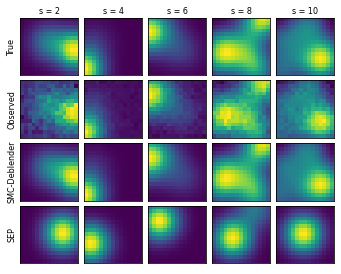

In [8]:
torch.manual_seed(0)

# Plot true intensities vs observed intensities vs SMC reconstruction
example_image_indexes = [torch.arange(num_images,device=device)[true_counts==2][torch.randint(low=0, high=(true_counts==2).sum(), size=(1,))].item(),
                         torch.arange(num_images,device=device)[true_counts==4][torch.randint(low=0, high=(true_counts==4).sum(), size=(1,))].item(),
                         torch.arange(num_images,device=device)[true_counts==6][torch.randint(low=0, high=(true_counts==6).sum(), size=(1,))].item(),
                         torch.arange(num_images,device=device)[true_counts==8][torch.randint(low=0, high=(true_counts==8).sum(), size=(1,))].item(),
                         torch.arange(num_images,device=device)[true_counts==10][torch.randint(low=0, high=(true_counts==10).sum(), size=(1,))].item()]
fig1_counts = true_counts[example_image_indexes]
fig1_true = true_total_intensities[example_image_indexes]
fig1_observed = images[example_image_indexes]
fig1_smc = smc_reconstruction[example_image_indexes]
fig1_sep = sep_reconstruction[example_image_indexes]

fig1,method = plt.subplots(nrows = 4, ncols = 5, sharex = True, sharey = True)
fig1.tight_layout(h_pad = -0.5, w_pad = -0.5)

for i in range(5):
    _ = method[0,i].imshow(fig1_true[i].cpu())
    _ = method[0,i].set_xlabel(f"s = {fig1_counts[i].int()}", fontsize = 8)
    _ = method[0,i].xaxis.set_label_position("top")
    _ = method[0,i].set_xticks([])
    _ = method[0,i].set_yticks([])

    _ = method[1,i].imshow(fig1_observed[i].cpu())
    _ = method[1,i].set_xticks([])
    _ = method[1,i].set_yticks([])

    _ = method[2,i].imshow(fig1_smc[i].cpu())
    _ = method[2,i].set_xticks([])
    _ = method[2,i].set_yticks([])

    _ = method[3,i].imshow(fig1_sep[i].cpu())
    _ = method[3,i].set_xticks([])
    _ = method[3,i].set_yticks([])

_ = method[0,0].set_ylabel("True", loc = "center", fontsize = 8)
_ = method[1,0].set_ylabel("Observed", loc = "center", fontsize = 8)
_ = method[2,0].set_ylabel("SMC-Deblender", loc = "center", fontsize = 8)
_ = method[3,0].set_ylabel("SEP", loc = "center", fontsize = 8)

fig1.subplots_adjust(wspace=-0.5)
fig1.savefig('results/fig1.png', dpi=1000)

### MSE, MAE, and calibration by true number of sources

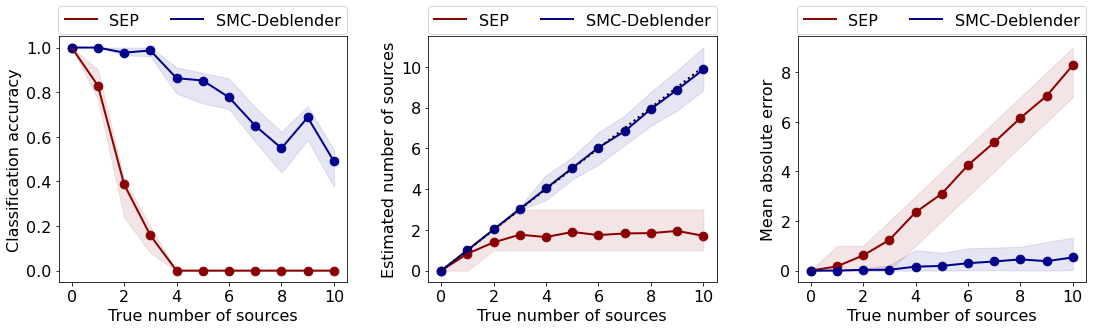

In [9]:
dot_size = 75
line_width = 2
text_size = 16
sep_color = "darkred"
smc_color = "darkblue"

range_max_objects = torch.arange(max_objects, device="cpu")

fig2, (fig2a,fig2b,fig2c) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
fig2.tight_layout(w_pad = 5)

_ = fig2a.plot(range_max_objects, sep_prop_correct_by_count.cpu(), label = "SEP", color = sep_color, linewidth = line_width)
_ = fig2a.scatter(range_max_objects, sep_prop_correct_by_count.cpu(), color = sep_color, s = dot_size)
_ = fig2a.fill_between(range_max_objects, sep_bounds_prop_correct_by_count[:,0].cpu(), sep_bounds_prop_correct_by_count[:,1].cpu(), color = sep_color, alpha = 0.1)
_ = fig2a.plot(range_max_objects, smc_prop_correct_by_count.cpu(), label = "SMC-Deblender", color = smc_color, linewidth = line_width)
_ = fig2a.scatter(range_max_objects, smc_prop_correct_by_count.cpu(), color = smc_color, s = dot_size)
_ = fig2a.fill_between(range_max_objects, smc_bounds_prop_correct_by_count[:,0].cpu(), smc_bounds_prop_correct_by_count[:,1].cpu(), color = smc_color, alpha = 0.1)
_ = fig2a.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
_ = fig2a.tick_params(axis = "both", labelsize = text_size)
_ = fig2a.set_xlabel("True number of sources", fontsize = text_size)
_ = fig2a.set_ylabel("Classification accuracy", fontsize = text_size)

_ = fig2b.plot(range_max_objects, sep_mean_estimated_count_by_count.cpu(), color = sep_color, label = "SEP", linewidth = line_width)
_ = fig2b.scatter(range_max_objects, sep_mean_estimated_count_by_count.cpu(), color = sep_color, s = dot_size)
_ = fig2b.fill_between(range_max_objects, sep_bounds_estimated_count_by_count[:,0].cpu(), sep_bounds_estimated_count_by_count[:,1].cpu(), color = sep_color, alpha = 0.1)
_ = fig2b.plot(range_max_objects, smc_mean_posterior_mean_count_by_count.cpu(), color = smc_color, label = "SMC-Deblender", linewidth = line_width)
_ = fig2b.scatter(range_max_objects, smc_mean_posterior_mean_count_by_count.cpu(), color = smc_color, s = dot_size)
_ = fig2b.fill_between(range_max_objects, smc_bounds_posterior_mean_count_by_count[:,0].cpu(), smc_bounds_posterior_mean_count_by_count[:,1].cpu(), color = smc_color, alpha = 0.1)
_ = fig2b.plot(range_max_objects, range_max_objects, ":", color="black", linewidth = line_width)
_ = fig2b.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
_ = fig2b.tick_params(axis = "both", labelsize = text_size)
_ = fig2b.set_xlabel("True number of sources", fontsize = text_size)
_ = fig2b.set_ylabel("Estimated number of sources", fontsize = text_size)

_ = fig2c.plot(range_max_objects, (sep_mae_by_count + smc_mae_by_count[0]).cpu(), label = "SEP", color = sep_color, linewidth = line_width)
_ = fig2c.scatter(range_max_objects, sep_mae_by_count.cpu(), color = sep_color, s = dot_size)
_ = fig2c.fill_between(range_max_objects, sep_bounds_mae_by_count[:,0].cpu(), sep_bounds_mae_by_count[:,1].cpu(), color = sep_color, alpha = 0.1)
_ = fig2c.plot(range_max_objects, (smc_mae_by_count).cpu(), label = "SMC-Deblender", color = smc_color, linewidth = line_width)
_ = fig2c.scatter(range_max_objects, smc_mae_by_count.cpu(), color = smc_color, s = dot_size)
_ = fig2c.fill_between(range_max_objects, smc_bounds_mae_by_count[:,0].cpu(), smc_bounds_mae_by_count[:,1].cpu(), color = smc_color, alpha = 0.1)
_ = fig2c.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
_ = fig2c.tick_params(axis = "both", labelsize = text_size)
_ = fig2c.set_xlabel("True number of sources", fontsize = text_size)
_ = fig2c.set_ylabel("Mean absolute error", fontsize = text_size)

fig2.savefig('results/fig2.png', bbox_inches = "tight", dpi = 1000)